sequence + multihtreading + show stats + export dot

 Eb/NO (dB) | Frame number |    BER   |    FER   |  Tpt (Mbps)
------------|--------------|----------|----------|------------
       0.00 |          107 | 1.58e-01 | 1.00e+00 |       1.16
       0.25 |          107 | 1.70e-01 | 1.00e+00 |       1.10
       0.50 |          107 | 1.47e-01 | 1.00e+00 |       1.13
       0.75 |          130 | 1.18e-01 | 8.15e-01 |       1.29
       1.00 |          151 | 1.01e-01 | 7.09e-01 |       1.41
       1.25 |          199 | 7.15e-02 | 5.33e-01 |       1.85
       1.50 |          392 | 3.24e-02 | 2.68e-01 |       2.80
       1.75 |         1289 | 1.17e-02 | 8.22e-02 |       5.24
       2.00 |         2611 | 4.68e-03 | 3.87e-02 |       6.58
       2.25 |         6319 | 1.83e-03 | 1.61e-02 |       6.75
# -------------------------------------------||------------------------------||--------------------------------||--------------------------------
#        Statistics for the given task       ||       Basic statistics       ||       Measured throughput   

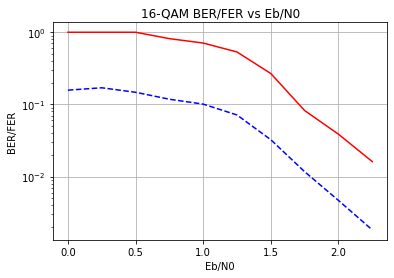

In [2]:

import sys
sys.path.insert(0, '../../build/lib')

import numpy as np
import py_aff3ct
import py_aff3ct.tools.sparse_matrix as sp
import time
import math
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '../../build/lib')
from py_aff3ct.module.py_module import Py_Module

# Step 1
class py_modulator(Py_Module):

    # Step 2
    def bpsk(self, b, x): # Your original code (independently from aff3ct)
        x[:] = 1.0 - 2.0*b[:]
        return 0
    
    # Step 3
    def __init__(self, N):
        # __init__ (step 3.1)
        Py_Module.__init__(self) # Call the aff3ct Py_Module __init__
        self.name = "py_BPSK"   # Set your module's name

        # __init__ (step 3.2)
        t_mod = self.create_task("modulate") # create a task for your module
        
        # __init__ (step 3.3)
        sb = self.create_socket_in (t_mod, "b", N, np.int32  ) # create an input socket for the task t_mod
        sx = self.create_socket_out(t_mod, "x", N, np.float32) # create an output socket for the task t_mod
    
        # __init__ (step 3.4)
        self.create_codelet(t_mod, lambda slf, lsk, fid: slf.bpsk(lsk[sb], lsk[sx])) # create codelet

# Build the modules

H   = sp.alist.read("../../lib/aff3ct/conf/dec/LDPC/WIMAX_288_576.alist")
N   = H.shape[0]
m   = H.shape[1]
K   = N-m
R   = K/N
bps = 1      # Bits per Symbols   
Ns  = N//bps # Packet size in symbols
I   = 100
FE  = 100

ebn0_min = 0.0
ebn0_max = 2.5
ebn0_step = 0.25

ebn0 = np.arange(ebn0_min,ebn0_max,ebn0_step)
esn0 = ebn0 + 10 * math.log10(R)
sigma_vals = 1/(math.sqrt(2) * 10 ** (esn0 / 20))

src  = py_aff3ct.module.source.Source_random           (K      )                                                   # Build source
enc  = py_aff3ct.module.encoder.Encoder_LDPC_from_H    (K, N, H)                                                   # Build the encoder
cstl = py_aff3ct.tools.constellation.Constellation_PSK(bps    )                                                   # Setup constellation tool

mdm    = py_aff3ct.module.modem.Modem_BPSK_fast(Ns)                                                   # Build the modem
my_mdm = py_modulator(Ns)


chn  = py_aff3ct.module.channel.Channel_AWGN_LLR       (Ns   )                                                   # Build the channel (Ns complex symbols = 2Ns real dims)
dec  = py_aff3ct.module.decoder.Decoder_LDPC_BP_horizontal_layered_inter_NMS (K, N, I, H, enc.get_info_bits_pos()) # Build the decoder
mnt  = py_aff3ct.module.monitor.Monitor_BFER_AR        (K,100  )                                                   # Build the monitor (counting errors)

src   ["generate   ::U_K"] = enc   ["encode      ::U_K"]
enc   ["encode     ::X_N"] = my_mdm["modulate    ::b  "]
my_mdm["modulate   ::x  "] = chn   ["add_noise   ::X_N"]
chn   ["add_noise  ::Y_N"] = mdm   ["demodulate ::Y_N1"] 

mdm["demodulate ::Y_N2"] = dec["decode_siho ::Y_N"]
dec["decode_siho::V_K" ] = mnt["check_errors ::V "]
src["generate    ::U_K"] = mnt["check_errors ::U "]

sigma = np.ndarray(shape = (1,1),  dtype = np.float32)
chn[ 'add_noise::CP'] = sigma
mdm['demodulate::CP'] = sigma

fer = np.zeros(len(ebn0))
ber = np.zeros(len(ebn0))

seq  = py_aff3ct.tools.sequence.Sequence(src["generate"], mnt["check_errors"], 8)

l_tasks = seq.get_tasks_per_types()
for lt in l_tasks:
    for t in lt:
        t.stats = True
        

print(" Eb/NO (dB) | Frame number |    BER   |    FER   |  Tpt (Mbps)")
print("------------|--------------|----------|----------|------------")
for i in range(len(sigma_vals)):
	mnt.reset()
	sigma[:] = sigma_vals[i]

	t = time.time()
	seq.exec()
	elapsed = time.time() - t
	total_fra = mnt.get_n_analyzed_fra()
	ber[i] = mnt.get_ber()
	fer[i] = mnt.get_fer()

	tpt = total_fra * K * 1e-6/elapsed
	print("%11.2f | %12d | %7.2e | %7.2e | %10.2f"%(ebn0[i], total_fra, ber[i], fer[i], tpt))
    
seq.show_stats()
seq.export_dot("sequence.dot")

fig = plt.figure()
plt.title("16-QAM BER/FER vs Eb/N0")
plt.xlabel("Eb/N0")
plt.ylabel("BER/FER")
plt.grid()
plt.semilogy(ebn0, fer, 'r-', ebn0, ber, 'b--')
plt.show()

